### Machine Learning for Systems & Control 5SC27 2020-2021

# Exercise set W2 Gaussian Processes

In this exercise set, you will implement your own version of a Radial Basis Function Gaussian Process, explore properties and explore how it can be used. 

## Exercise 1: Writing your own GP

**a)** Based on Slide 32 and 20 for Lecture 2, implement GP regression with $\sigma_e^2 = 0.1$ (expected noise variance) and a squared exponential kernel with $\sigma^2 = 0.1$ (kernel width) using the `lownoise.mat` (place contents of the `dataW2.zip` in the same folder as the notebook) data set and plot the resulting function estimate on a fine grid of `xtest = np.linspace(-1,1,num=300)`. Analyse the qualitative fit w.r.t. the data. 

*tip: start by (i) finishing the `kernal` function than use the `kernal` function in (i) `compute_alpha` and use that in (iii) `pred_mean_and_var` to compute the mean.*

*tip: use np.linalg.solve instead of np.linalgh.inv*

$\hat \alpha = \left ( K_{xx} + \sigma_e^2 I_N \right ) ^{-1} Y$

**b)** Compute the resulting variance of the function estimate (slide 20) of 1.a and plot 2 time the standard deviation (95% confidence bound) of the function. You can use the second part of `pred_mean_and_var` to complete this.

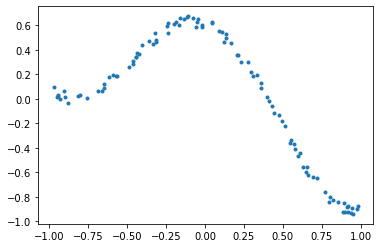

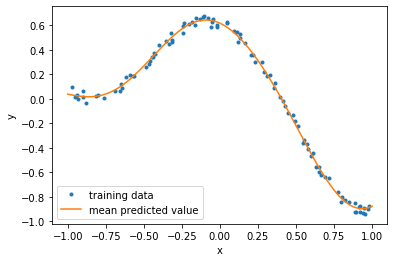

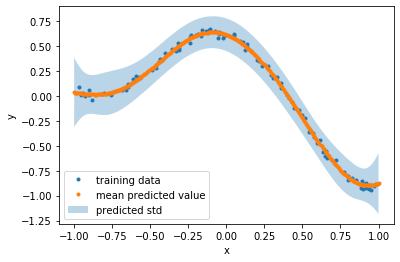

In [3]:
from scipy.io import loadmat
import numpy as np

######### selecting dataset 'low', 'med' or 'high'  #########
ident = 'low'

#load data
out = loadmat(f'{ident}noise.mat') #train data
x = out['x'][:,0] #shape=(N,)
y = out['y'][:,0] #shape=(N,)
out = loadmat(f'valid_{ident}noise.mat') #validation data
xval = out['x'][:,0] #shape=(Nval,)
yval = out['y'][:,0] #shape=(Nval,)

xtest = np.linspace(-1,1,num=300) #xpoints for visualization


from matplotlib import pyplot as plt
plt.plot(x,y,'.')
plt.show()

def kernal(x1, x2, sigma2_ker):
    #make a matrix for two given inputs arrays
    #input: 
    #x1 of shape (N1)
    #x2 of shape (N2)
    #sigma2_ker float the squared kernel width
    
    #output
    #Kxx of shape (N1,N2)
    #Kxx[i,j] = np.exp(-(x1[i]-x2[j])**2/(2*sigma2_ker))) #a)
    
    #fast and compact: #a)
    diff = x1[:,None] - x2[None,:] #make a diff matrix of size (N1,N2) #a)
    Kxx = np.exp(-diff**2/(2*sigma2_ker)) #a)
    
#     #slow and explicit: #a)
#     Kxx = np.zeros(shape=(len(x1),len(x2))) #a)
#     for i in range(len(x1)): #a)
#         for j in range(len(x2)): #a)
#             Kxx[i,j] = np.exp(-(x1[i]-x2[j])**2/(2*sigma2_ker)) #a)
    
    return Kxx

def compute_alpha(x, y, sigma2_es, sigma2_ker):
    #for a given x and y data computes the alpha and Kxx 
    #uses the kernal function from above

    Kxx = kernal(x, x, sigma2_ker) #a=)
    alpha = np.linalg.solve(Kxx+sigma2_es*np.eye(len(x)), y) #a=)
    return alpha, Kxx #return both alpha and Kxx (required for variance estimation)

    
    
def pred_mean_and_var(xtest, x, Kxx, alpha, sigma2_es, sigma2_ker, return_std=True): 
    #conditionally return the standard deviation  
    K = lambda x1,x2: kernal(x1, x2, sigma2_ker=sigma2_ker) #shorthand for the kernal function use as K(x1,x2)
    
    Ktx = K(xtest, x) #a=)
    Ypred_mean = Ktx@alpha #a=)
    
    if not return_std:
        return Ypred_mean

    #finished at b)
#     Ypred_var = 
    #slow way: #b) 
    #Ypred_var = np.diag(K(xtest,xtest) - Ktx@np.linalg.inv(Kxx+sigma2_es*np.eye(len(x)))@Ktx.T) #b)
    #fast way: #b)
    Ypred_var = np.diag(K(xtest,xtest) - Ktx@np.linalg.solve(Kxx+sigma2_es*np.eye(len(x)), Ktx.T)) #b)
    
    return Ypred_mean, Ypred_var**0.5
    
sigma2_es = 0.1
sigma2_ker = 0.1
alpha, Kxx = compute_alpha(x, y, sigma2_es, sigma2_ker) # a) finish compute_alpha  
Ypred_mean = pred_mean_and_var(xtest, x, Kxx, alpha, sigma2_es, sigma2_ker, return_std=False) # a) finish pred_mean_and_var  

plt.plot(x,y,'.')
plt.plot(xtest,Ypred_mean)
plt.ylabel('y'); plt.xlabel('x'); plt.legend(['training data','mean predicted value'])
plt.show()

if True: #switch to true when on b)
    Ypred_mean, Ypred_std = pred_mean_and_var(xtest, x, Kxx, alpha, sigma2_es, sigma2_ker)
    plt.plot(x,y,'.')
    plt.plot(xtest,Ypred_mean,'.')
    plt.fill_between(xtest,Ypred_mean-2*Ypred_std,Ypred_mean+2*Ypred_std,alpha=0.3)
    plt.ylabel('y'); plt.xlabel('x'); plt.legend(['training data','mean predicted value','predicted std'])
    plt.show()

**c)** Write down the influence of the kernel width $\sigma$ and the $\sigma_e$ on the predictions using the figures generated in the cell below.

**Answer c):** $\sigma_e$ regulates the uncertainty of each measurement point and $\sigma$ regulates the area each point can influence. 

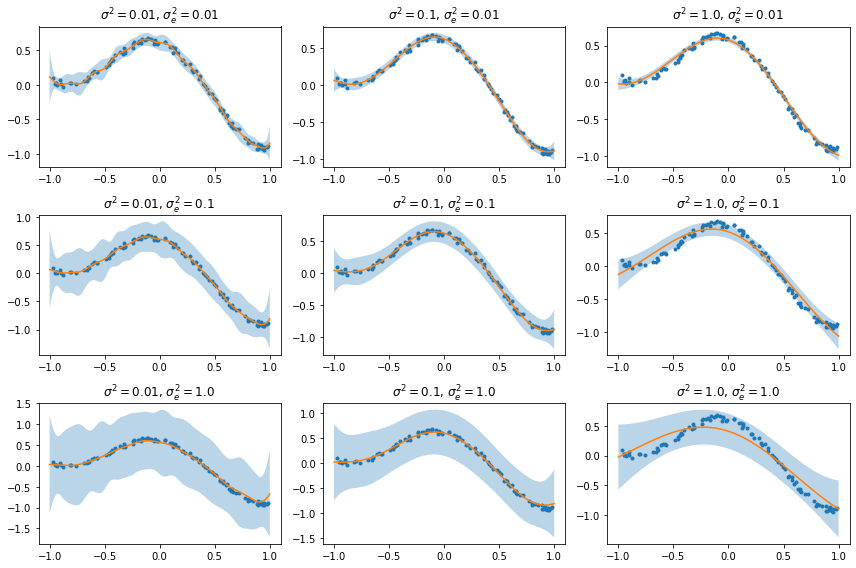

In [5]:
def plot(x,y,xtest,sigma2_es,sigma2_ker):
    
    alpha, Kxx = compute_alpha(x, y, sigma2_es, sigma2_ker)
    Ypred_mean, Ypred_std = pred_mean_and_var(xtest, x, Kxx, alpha, sigma2_es, sigma2_ker)
    
    plt.title(f'$\\sigma^2 = {sigma2_ker}$, $\\sigma^2_e = {sigma2_es}$ ')
    plt.plot(x,y,'.')
    plt.plot(xtest,Ypred_mean)
    plt.fill_between(xtest,Ypred_mean-2*Ypred_std,Ypred_mean+2*Ypred_std,alpha=0.3)
    plt.tight_layout()


plt.figure(figsize=(12,8))
i = 0
for sigma2_es in [0.01,0.1,1.0]:
    for sigma2_ker in [0.01,0.1,1.0]:
        i+=1
        plt.subplot(3,3,i)
        plot(x,y,xtest,sigma2_es,sigma2_ker)

plt.show()


**d)** Implement a grid search for $\sigma_e$ and $\sigma$ using the validation set (`xval` and `yval`). Complete the RMS function below and iterate over both arrays to create the grid. Use the cell after the next one to visualize the result. Does this result seem sensible?

**Answer d):** The resulting mean is overly aggressive and/or standard deviation way too small.

In [6]:
def RMS(x, y, xval, yval, sigma2_es, sigma2_ker):
    alpha, Kxx = compute_alpha(x, y, sigma2_es, sigma2_ker) #d)
    yval_mean_pred = pred_mean_and_var(xval, x, Kxx, alpha, sigma2_es, sigma2_ker, return_std=True) #d)
    return np.mean((yval_mean_pred - yval)**2)**0.5 #d)

sigma2_es_list = np.geomspace(0.001,3,num=21) #increasing value in log space
sigma2_ker_list = np.geomspace(0.001,2,num=22) #increasing value in log space


mat_out = [] #d)
for sigma2_es in sigma2_es_list: #d)
    print(sigma2_es) #d)
    mat_out_row = [] #d)
    for sigma2_ker in sigma2_ker_list: #d)
        mat_out_row.append(RMS(x, y, xval, yval, sigma2_es, sigma2_ker)) #d)
    mat_out.append(mat_out_row) #d)
RMS_mat = np.array(mat_out) #d=)

0.001
0.0014922997379927746
0.0022269585080133014
0.00332328959802903
0.00495934419641283
0.0074008280449228536
0.011044253752367953
0.016481336980984404
0.024595094858493642
0.03670325361323748
0.05477225575051662
0.08173662290576919
0.12197554094669359
0.1820240677962776
0.27163446868076413
0.40536004644211043
0.6049186910983003
0.9027200042329258
1.3471288257976302
2.0103199937803176
3.0


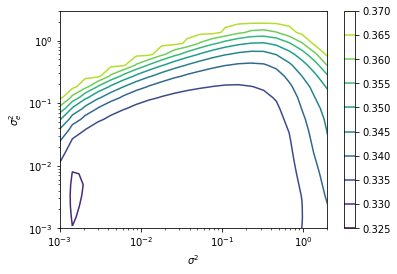

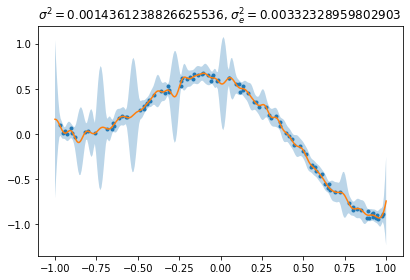

In [7]:
#plotting for d)
plt.contour(sigma2_ker_list, sigma2_es_list, np.clip(RMS_mat,-float('inf'),np.percentile(RMS_mat.flat,80)))
plt.loglog()
plt.colorbar()
plt.xlabel(r'$\sigma^2$')
plt.ylabel(r'$\sigma_e^2$')
plt.show()

best1, best2 = np.unravel_index(np.argmin(RMS_mat),RMS_mat.shape)
sigma2_ker_list[best2], sigma2_es_list[best1]
plot(x,y,xtest,sigma2_es_list[best1],sigma2_ker_list[best2])
plt.show()

**e)** Do the same for the marginal log-likelihood and afterwards use the `minimize` from `scipy.optimize` to find the maximum.

$$
\text{loglike} = 1/N \sum_i \log \left ( \frac{1}{\sigma \sqrt{2 \pi} }  e^{-(y_i-\hat{y_i})^2/(2 \sigma_y^2)}  \right ) 
$$

*tip: rewrite the expression above such to reduce floating-point errors*

In [5]:
def loglike(x, y, xval, yval, sigma2_es, sigma2_ker):
    alpha, Kxx = compute_alpha(x, y, sigma2_es, sigma2_ker)
    yval_mean_pred, yval_std = pred_mean_and_var(xval, x, Kxx, alpha, sigma2_es, sigma2_ker, return_std=True) 
    
    
    loglike = np.mean(-(yval-yval_mean_pred)**2/(2*yval_std**2) - np.log(yval_std) - np.log(2*np.pi)/2) #e=)

    return loglike

sigma2_es_list = np.geomspace(0.001,2,num=21)
sigma2_ker_list = np.geomspace(0.001,2,num=23)
mat_out_like = []
for sigma2_es in sigma2_es_list:
    print(sigma2_es)
    mat_out_row = []
    for sigma2_ker in sigma2_ker_list:
        mat_out_row.append(loglike(x, y, xval, yval, sigma2_es, sigma2_ker))
    mat_out_like.append(mat_out_row)
mat_out_like = np.array(mat_out_like)

0.001
0.0014623505735569615
0.0021384691999823766
0.003127191661128125
0.004573050519273265
0.00668740304976422
0.009779327685429282
0.01430080544978899
0.02091279105182546
0.03058183198931387
0.044721359549995794
0.06539830578818345
0.09563524997900368
0.13985226265905948
0.2045130365127145
0.29906975624424414
0.4373448295773111
0.6395514623745525
0.9352484478226213
1.3676611040916682
2.0


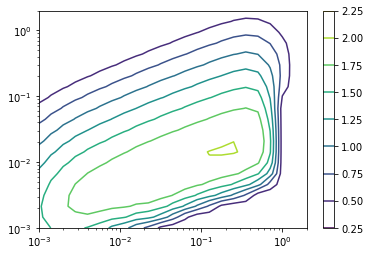

0.17811572778760928 0.01430080544978899
2.0113690546634126


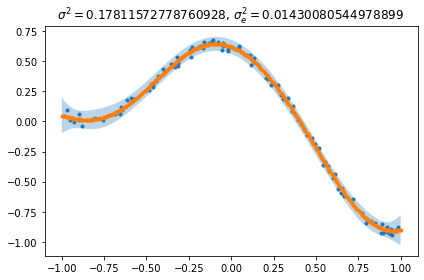

In [6]:
#plotting for e)
plt.contour(sigma2_ker_list, sigma2_es_list, np.clip(mat_out_like,np.percentile(mat_out_like.flat,30),float('inf')))
plt.colorbar()
plt.loglog()
plt.show()
best1, best2 = np.unravel_index(np.argmax(mat_out_like),mat_out_like.shape)
print(sigma2_ker_list[best2], sigma2_es_list[best1])
print(np.max(mat_out_like))
plot(x,y,xtest,sigma2_es_list[best1],sigma2_ker_list[best2])

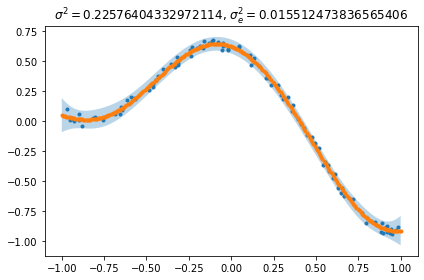

In [7]:
from scipy.optimize import minimize
#fun(x, *args) -> float (see docs)

# maximize marginal log likelihood
fun = lambda th: -loglike(x, y, xval, yval, th[0], th[1]) #e)
x0 = [sigma2_es_list[best1],sigma2_ker_list[best2]] #e)
fsol = minimize(fun, x0,bounds=[[1e-3,4],[1e-3,4]]) #e=)
# fsol = minimize(...)

sigma2_es_best, sigma2_ker_best = fsol.x
plot(x,y,xtest,sigma2_es_best, sigma2_ker_best)
plt.show()

## Exercise 2: Using sklearn GP

Now that you understand the basics of gaussian processing let's switch to a nicely implemented version included in sklearn [1.7 Gaussian Processes](https://scikit-learn.org/stable/modules/gaussian_process.html). It includes features like:

* The hyperparameters of the kernel are optimized during the fitting of `GaussianProcessRegressor` by maximizing the log-marginal-likelihood (LML) (and using `scipy.optimize.minimize`). 
* Different kernels can be specified. Common kernels are provided, but it is also possible to specify custom kernels.

**a)** Noise term $\sigma_e$ can be interpreted as a kernel and is used as such in sklearn. Which kind of kernel $k(x_i, x_j)$ would produce the desired behaviour of a noise term.

**Answer a):** $k(x_i, x_j) = \delta_{ij} \sigma_e$ 

**b)** Using the x and y data generated below construct a kernel as a Radial Basis Function `RBF` and `WhiteKenel` using `+` and estimate the model. Show the resulting model with `.predict` (set `return_std=True`).

*tip: read the documentation of gaussian processes provided here [function doc](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html), [User guide](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process)*

*tip: set n_restarts_optimizer=10 for more robust hyperparamter optimization*

*note: sklearn is multi-variate inputs so the x arrays need to have the shape of `(Nsamp, Nfeatures)` with `Nfeatures=1`*

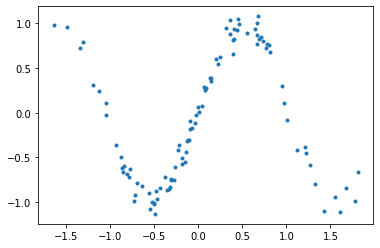

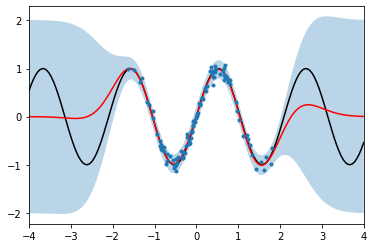

In [14]:
# f0 = lambda x: np.sin(3*x) + 0.5*np.random.normal(loc=0,scale=0.9,size=x.shape)
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(43)
N = 100
noise = 0.1
f0 = lambda x: np.sin(3*x)

x = np.random.normal(loc=0,scale=0.8,size=N)
y = f0(x) + noise*np.random.normal(loc=0,scale=0.9,size=x.shape)
xtest = np.linspace(-4,4,num=150)
ytest = f0(xtest)

plt.plot(x,y,'.')
plt.show()


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared


#construct kernal
ker = RBF(length_scale=1) + WhiteKernel(noise_level=1.0) #b=)
#construct regressor
reg = GaussianProcessRegressor(ker,n_restarts_optimizer=10) #b=)
#fit regressor
reg.fit(x[:,None],y) 
#use regressor
ytest_p, ytest_std = reg.predict(xtest[:,None],return_std=True) #b=)

#plot result
plt.plot(xtest,ytest,'k')
plt.plot(xtest,ytest_p,'r')
plt.xlim(min(xtest),max(xtest))
plt.fill_between(xtest,ytest_p-2*ytest_std,ytest_p+2*ytest_std,alpha=0.3)
plt.plot(x,y,'.')
plt.show()


Gaussian processes are probabilistic in nature, hence we can sample them. 

**c)** Sample the obtained Gaussian process using `reg.sample_y` 7 times on the test set and plot and interpret the results.

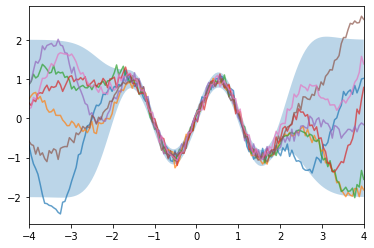

In [18]:
ysamps = reg.sample_y(xtest[:,None],n_samples=7) #c=)

plt.plot(xtest,ysamps,alpha=0.7)
plt.fill_between(xtest,ytest_p-2*ytest_std,ytest_p+2*ytest_std,alpha=0.3)
plt.xlim(min(xtest),max(xtest))
plt.show()

**d)** Repeat the exercise trying out some other kernels provided in sklearn [Kernals](https://scikit-learn.org/stable/modules/gaussian_process.html#kernel-operators), for instance, the Exp-Sine-Squared kernel (`ExpSineSquared`).

As seen in the implementation solving a GP requires solving a system of equations of $A x = y$ with a $A$ a shape of `(Nsamp,Nsamp)` which scales worst than linear with increasing data size. 

**e)** Measure the time it takes to estimate a model for different dataset sizes for `range(100,2500,200)` and save the time it takes to an array and observe the scaling by plotting these saved times. (this question should not take more than a minute)

*tip: use time.time() to get the current time in seconds from the time module*

**f)** How does the computation time scale with the number of samples (linear or worse?)

**Answer f):** Approximately quadratic

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
import numpy as np
def test(Nsamples):
    N = Nsamples
    noise = 0.1
    f0 = lambda x: np.sin(3*x)

    x = np.random.normal(loc=0,scale=0.8,size=N)
    y = f0(x) + noise*np.random.normal(loc=0,scale=0.9,size=x.shape)

    reg = GaussianProcessRegressor(RBF(length_scale=1) + WhiteKernel(noise_level=1.0)) 
    reg.fit(x[:,None],y) 
    return reg

import time
Nsamples_list = range(100,2500,200)
time_list = [] #e)
for Nsamples in Nsamples_list: #e)
    t_start = time.time() #e)
    test(Nsamples) #e)
    time_elapsed = time.time() - t_start #e)
    print(Nsamples, time_elapsed,'seconds') #e)
    time_list.append(time_elapsed) #e)

100 0.019946575164794922 seconds
300 0.10272622108459473 seconds
500 0.4827094078063965 seconds
700 0.6562392711639404 seconds
900 0.6858077049255371 seconds
1100 1.1956284046173096 seconds
1300 1.7642526626586914 seconds
1500 2.1962666511535645 seconds
1700 3.4937214851379395 seconds
1900 4.69180154800415 seconds
2100 6.6254048347473145 seconds
2300 7.401102542877197 seconds


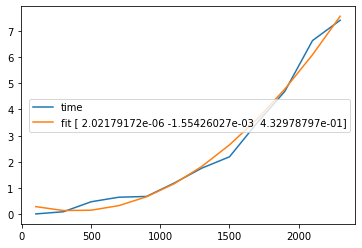

In [11]:
#plotting here
plt.plot(Nsamples_list,time_list)#e)
p = np.polyfit(Nsamples_list,time_list,2) #poly fit #e)
f = lambda x: p[0]*x**2 + p[1]*x + p[2] #e)
plt.plot(Nsamples_list,[f(n) for n in Nsamples_list]) #e)
plt.legend(['time',f'fit {p}']) #e)
plt.show() #e)

## Exercise 3: NARX

From the last exercise, we saw that GP can estimate non-linear models. For this exercise we will apply it to the same example we have in the last exercise set (Week 1). 

**a)** Construct the data arrays `Xtrain, Xval, Ytrain, Yval` using the cell below and estimate a GP with RBF and white kernel. Just as before making a residual plot of both the training and validation data. Now also include the uncertainty in the residual plot as a bar plot ([matplotlib errorbar plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html))


In [12]:
import numpy as np
from matplotlib import pyplot as plt
def f(upast,ypast):
    ukm2, ukm1 = upast
    ykm2, ykm1 = ypast
    ystar = (0.8 - 0.5 * np.exp(-ykm1 ** 2)) * ykm1 - (0.3 + 0.9 * np.exp(-ykm1 ** 2)) * ykm2 \
           + ukm1 + 0.2 * ukm2 + 0.1 * ukm1 * ukm2
    return ystar + np.random.normal(scale=0.01)

def get_NARX_data(ulist, f, na, nb):
    #init upast and ypast as lists.
    upast = [0]*nb 
    ypast = [0]*na 
    
    ylist = []
    for unow in ulist:
        #compute the current y given by f
        ynow = f(upast,ypast) 
        
        #update past arrays
        upast.append(unow)
        upast.pop(0)
        ypast.append(ynow)
        ypast.pop(0)
        
        #save result
        ylist.append(ynow)
    return np.array(ylist) #return result

na, nb = 2, 2

np.random.seed(42)
N = 500
ulist = np.random.normal(scale=1,size=N)
ylist = get_NARX_data(ulist,f,na,nb)

def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the first few indexes such to 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 
    return np.array(Xdata), np.array(Ydata)

Xdata, Ydata = make_training_data(ulist,ylist, 2, 2)

from sklearn.model_selection import train_test_split 
Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata) 

In [13]:
#fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared

ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01) #e=)
reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10) #e=)
reg.fit(Xtrain,Ytrain) #e)

GaussianProcessRegressor(kernel=RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=10)

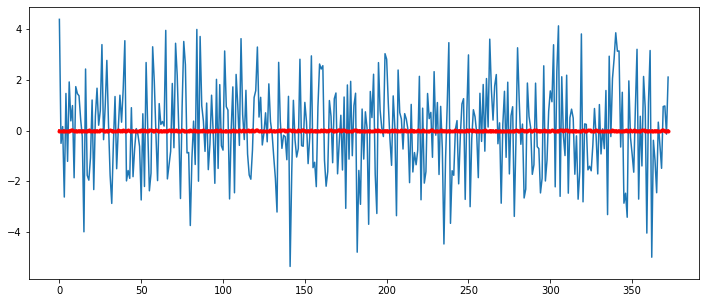

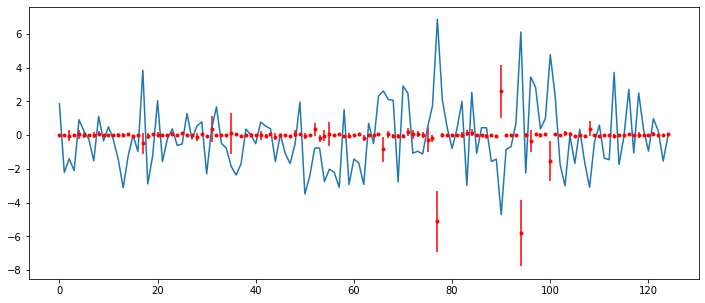

In [14]:
#residual calculations and plotting
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) #e)
res = Ytrain_pred - Ytrain #e)
plt.figure(figsize=(12,5)) #e)
plt.plot(Ytrain) #e)
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) #e)
plt.errorbar(np.arange(len(Xtrain)), (reg.predict(Xtrain)-Ytrain), yerr=2*Ytrain_pred_std,fmt='.r') #e)
plt.show() #e)

plt.figure(figsize=(12,5)) #e)
plt.plot(Yval) #e)
Yval_pred, Yval_pred_std = reg.predict(Xval,return_std=True) #e)
plt.errorbar(np.arange(len(Xval)), (reg.predict(Xval)-Yval), yerr=2*Yval_pred_std,fmt='.r') #e)
plt.show() #e)

**b)** Just as before we are also interested in the simulator performance of the model. Make a simulation and plot the residual and the NRMS. Is it lower than the polynomial model of the last exercise set?

**c)** Retry the exercise with different kernels and see if you can construct a kernel that is more accurate.

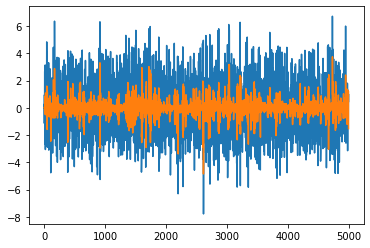

NRMS= 0.2857673509900122


In [15]:

np.random.seed(43)
utest = np.random.normal(scale=1.0,size=5000)
ytest = get_NARX_data(utest,f,na,nb)


model_now = reg #b=)
ytest_sim = get_NARX_data(utest,lambda u,y: model_now.predict(np.concatenate([u,y])[None,:])[0], na, nb)
plt.plot(ytest) #b)
plt.plot(ytest-ytest_sim) #b)
plt.show() #b)

print('NRMS=',np.mean((ytest-ytest_sim)**2)**0.5/np.std(ytest)) #b)


## Exercise 4: Bayesian optimization

In this exercise, we will explore the basics of Bayesian Optimization. Consider the same setting as in Exercise 2, but now with a slightly modified process as seen below. 

**a)** In this case, we will only use 10 randomly generated training samples (N = 10) using the measurement function `f` and we will iteratively add new samples to refine our prediction for the possible function values. Define the test set as `xtest = np.linspace(-3,3,num=1000)`. After training for the 10 initial samples compute the standard deviation of the predicted function values over the test set and chose the location where it is the largest. Now, add the chosen test point to the training set and compute its corresponding y by the given formula `f`. Repeat this process until you have 20 samples and see how the resulting function estimate and its 95% confidence bound improving. Do you get a better estimate than with 20 randomly chosen samples? Plot the results below

*tip: use np.argmax and np.append*


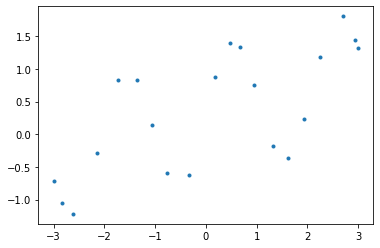

In [8]:
import warnings
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
warnings.filterwarnings("ignore") #there might be some warning but this will supress them.

f0 = lambda x: np.sin(3*x) + 0.2*x + 0.3 #no noise version
f = lambda x: f0(x) + np.random.normal(scale=0.002,size=np.array(x).shape) #noisy version

Ntotal = 20 #number of total points
Nstart = 10 #inital points

x = np.random.uniform(low=-3,high=3,size=Nstart) #a=)
y = f(x) #a=)

xtest = np.linspace(-3,3,num=1000) #a=)

def get_model(x,y): 
    #return a regressor which is fitted to x,y
    ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01) #a)
    reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10) #a)
    reg.fit(x[:,None],y) #a)
    return reg #a)


for i in range(Ntotal-Nstart):
    reg = get_model(x,y) #a)
    ytest_pred_mean, ytest_pred_std = reg.predict(xtest[:,None],return_std=True) #a)
    xnew = xtest[np.argmax(ytest_pred_std)] #a)
    ynew = f(xnew) #a)
    x = np.append(x,xnew) #a)
    y = np.append(y,ynew) #a)
plt.plot(x,y,'.') #a)
plt.show() #a)

    

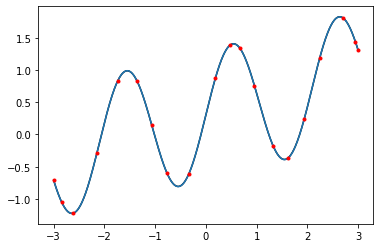

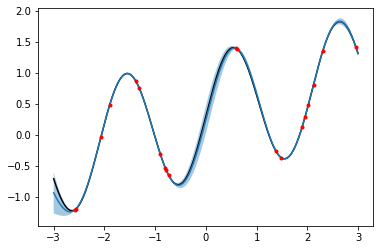

In [9]:
reg_op = get_model(x,y)
xrand = np.random.uniform(low=-3,high=3,size=Ntotal)
yrand = f(xrand)
reg_rand = get_model(xrand,yrand)

for xnow, ynow, reg in [(x,y,reg_op), (xrand,yrand,reg_rand)]:
    ytest_pred_mean, ytest_pred_std = reg.predict(xtest[:,None],return_std=True)
    plt.plot(xtest,f0(xtest),'k')
    plt.plot(xtest,ytest_pred_mean)
    plt.plot(xnow,ynow,'.r')
    plt.fill_between(xtest,ytest_pred_mean-2*ytest_pred_std,ytest_pred_mean+2*ytest_pred_std,alpha=0.4)
    plt.show()



**b)** We can also use the same methodology to explore the maximum value of the function. Apply the same approach as above, but, in this case, select the new training point as the maximum of the weighted sum of the mean and the standard deviation, like: 

`((1-weight)*ytest_pred_mean+weight*ytest_pred_std)` Use first weight=0.5. Do you get the maximum of the function after 10 iterations? Explore the effect of choosing the weight to be high (≥ 0.85) and low (≤ 0.25).

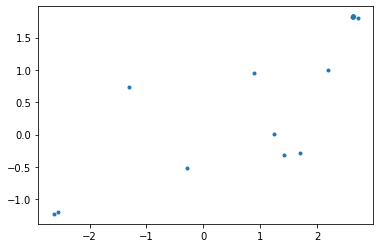

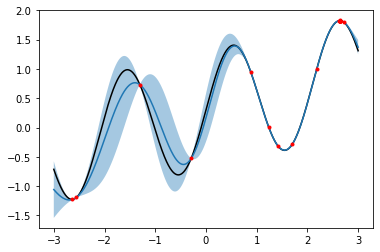

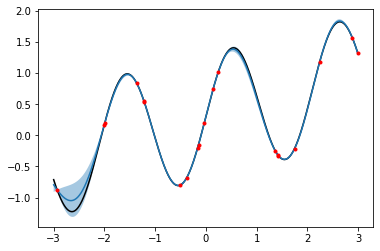

In [10]:
import warnings
warnings.filterwarnings("ignore")

f0 = lambda x: np.sin(3*x) + 0.2*x + 0.3 #no noise version
f = lambda x: f0(x) + np.random.normal(scale=0.002,size=np.array(x).shape) #noisy version

Ntotal = 20
Nstart = 10
weight = 0.5 #b=)

x = np.random.uniform(low=-3,high=3,size=Nstart)
y = f(x)

xtest = np.linspace(-3,3,num=1000)

def get_model(x,y):
    ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01) 
    reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10) 
    reg.fit(x[:,None],y)
    return reg


for i in range(Ntotal-Nstart):
    reg = get_model(x,y) 
    ytest_pred_mean, ytest_pred_std = reg.predict(xtest[:,None],return_std=True) 
    xnew = xtest[np.argmax((1-weight)*ytest_pred_mean + weight*ytest_pred_std)] #b=)
    ynew = f(xnew) 
    x = np.append(x,xnew) 
    y = np.append(y,ynew) 
plt.plot(x,y,'.') 
plt.show() 

reg_op = get_model(x,y)
xrand = np.random.uniform(low=-3,high=3,size=Ntotal)
yrand = f(xrand)
reg_rand = get_model(xrand,yrand)

for xnow, ynow, reg in [(x,y,reg_op), (xrand,yrand,reg_rand)]:
    ytest_pred_mean, ytest_pred_std = reg.predict(xtest[:,None],return_std=True)
    plt.plot(xtest,f0(xtest),'k')
    plt.plot(xtest,ytest_pred_mean)
    plt.plot(xnow,ynow,'.r')
    plt.fill_between(xtest,ytest_pred_mean-2*ytest_pred_std,ytest_pred_mean+2*ytest_pred_std,alpha=0.4)
    plt.show()



The grid-based optimization that we used above is not guaranteed to find precisely global
optimum of the selection problem, neither it is applicable in case of high dimensions of x.
Hence, direct maximization over the covariance function is suggested,
however, in that case the problem of finding the global optimum can still seriously affect the
outcome. Hence random initializations or swarm optimization can achieve better outcomes.
